توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [1]:
## download data
%%capture

!curl --output release_test.zip --url http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!curl --output ADEChallengeData2016.zip --url http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

UsageError: Line magic function `%%capture` not found.


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [3]:
def displacement(img):
  height, width = img.shape[:2]
  x = randint(-10, 10)
  y = randint(-10, 10)
  M = np.float32([[1,0,x],[0,1,y]])
  img = cv2.warpAffine(img,M,(width,height))
  return img

def rotation(img):
  angle = randint(-10, 10)
  height, width = img.shape[:2]
  image_center = (width/2, height/2)
  rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)
  abs_cos = abs(rotation_mat[0,0])
  abs_sin = abs(rotation_mat[0,1])
  bound_w = int(height * abs_sin + width * abs_cos)
  bound_h = int(height * abs_cos + width * abs_sin)
  rotation_mat[0, 2] += bound_w/2 - image_center[0]
  rotation_mat[1, 2] += bound_h/2 - image_center[1]
  rotated_mat = cv2.warpAffine(img, rotation_mat, (bound_w, bound_h))
  return rotated_mat

def scaling(img):
  scale = np.random.uniform(0.5, 1.5)
  img = cv2.resize(img, None, fx = scale, fy = scale, interpolation = cv2.INTER_CUBIC)
  return img

def Brightness(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
  img = np.array(img, dtype = np.float64)
  random_bright = .5 + np.random.uniform()
  img[:,:,2] = img[:,:,2] * random_bright
  img[:,:,2][img[:,:,2]>255]  = 255
  img = np.array(img, dtype = np.uint8)
  img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
  return img

def bluring(img):
  kernel_size = randint(1, 5)
  blured_img = cv2.blur(img, (kernel_size, kernel_size))
  return blured_img

def gaussian_noise(img):
  noised_img = cv2.add(img, np.random.normal(0, 1, img.shape))
  return noised_img

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data_type: str = 'training'):
        if data_type != 'training' and data_type != 'validation' and data_type != 'testing':
          raise ValueError('data_type must be training, validation or testing')
        self.imgs = glob.glob(f'ADEChallengeData2016/images/{data_type}/*.jpg')
        self.imgs.sort()

    def __getitem__(self,idx):
        img = IM(self.imgs[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_original = img.copy()
        label = [0, 0, 0]
        count = randint(0, 3)
        for i in range(count):
          aug = randint(0, 2)
          if aug == 0:
            img = displacement(img)
            label[0] = 1
          elif aug == 1:
            img = rotation(img)
            label[1] = 1
          elif aug == 2:
            img = scaling(img)
            label[2] = 1
        img = cv2.resize(img, (224, 224))
        img_original = cv2.resize(img_original, (224, 224))
        img = img/255
        img_original = img_original/255
        img = np.transpose(img, (2, 0, 1))
        img_original = np.transpose(img_original, (2, 0, 1))
        img = torch.tensor(img, dtype=torch.float32)
        img_original = torch.tensor(img_original, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)
        label = label / torch.sum(label)
        return img_original, img, label
    
    def __len__(self):
        return len(self.imgs)

In [5]:

dataset_train = CustomDataset('training')
dataset_test = CustomDataset('testing')
dataset_val = CustomDataset('validation')


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader= DataLoader(dataset_test, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=True)

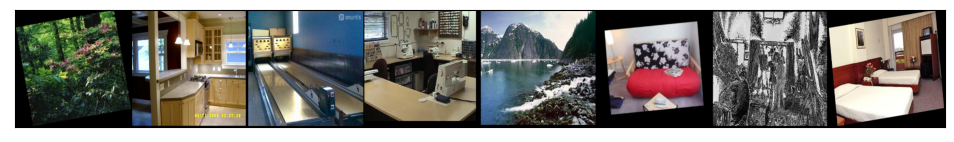

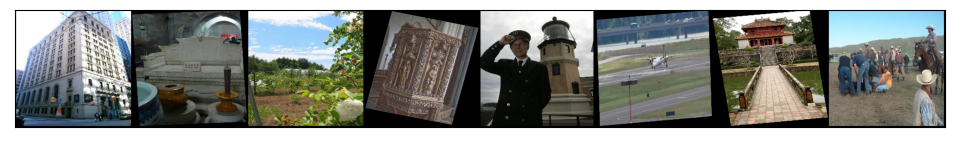

In [6]:
## To Do  : show 8 images from train_loader & 8 images from test_loader

import torchvision

def show_images(images, nmax=8):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(np.transpose(torchvision.utils.make_grid(
        images.detach()[:nmax], nrow=8, padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.show()

for i, (_, images, _) in enumerate(train_loader):
    if i == 0:
        show_images(images)
        break

for i, (_, images, _) in enumerate(test_loader):
    if i == 0:
        show_images(images)
        break

##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

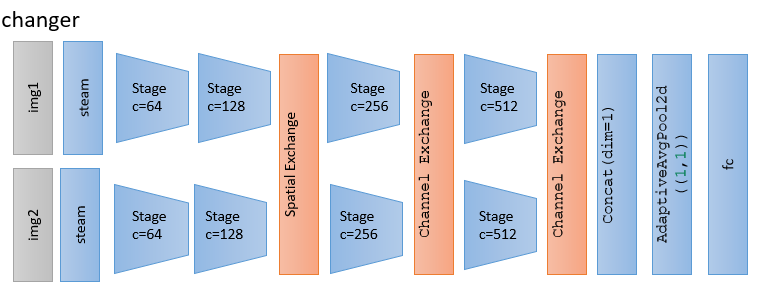

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


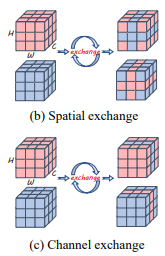

In [7]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

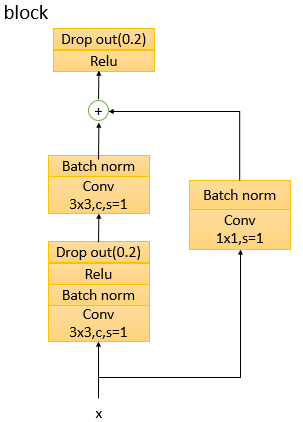

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
 مقدار خروجی هر دو قسمت باید برابر باشد در نتیجه جفت آن‌ها به تعداد out_channels هستند و پدینگ را بگونه‌ای اضافه کردیم که سایز عکس تغییر نکند.
 در لایه‌های با کرنل ۳ مقدار را ۱ و در لایه‌های با کرنل ۱ مقدار ۰.
2.  دلیل استفاده از کانولوشن 1در1 چیست؟
مدیریت تعداد چنل‌ها و کاهش حجم محاسبات.

In [8]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.dropout1 = nn.Dropout2d(0.2)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsample = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
      nn.BatchNorm2d(out_channels)
    )
    self.dropout2 = nn.Dropout2d(0.2)

  def forward(self,x):
    residual = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.dropout1(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = out + self.downsample(residual)
    out = self.relu(out)
    out = self.dropout2(out)
    return out

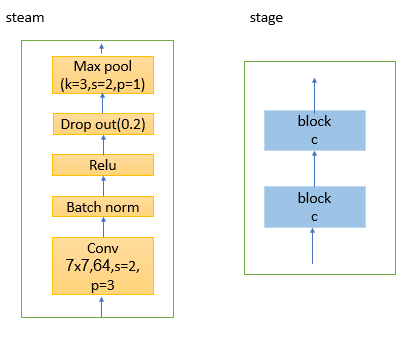

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [12]:
#To Do
class Changer(nn.Module):
  def __init__(self):
    super(Changer,self).__init__()

    self.stem=nn.Sequential(
      nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3,bias=False),
      nn.BatchNorm2d(64),
      nn.ReLU(inplace=True),
      nn.Dropout2d(0.2),
      nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    )

    self.stage1 = nn.Sequential(
      ResidualBlock(64,64),
      ResidualBlock(64,64)
    )
    self.stage2 = nn.Sequential(
      ResidualBlock(64,128,stride=2),
      ResidualBlock(128,128)
    )
    self.stage3 = nn.Sequential(
      ResidualBlock(128,256,stride=2),
      ResidualBlock(256,256)
    )
    self.stage4 = nn.Sequential(
      ResidualBlock(256,512,stride=2),
      ResidualBlock(512,512)
    )
    self.pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(1024,3)
    self.exchange_1 = SpatialExchange()
    self.exchange_2 = ChannelExchange()
    self.exchange_3 = ChannelExchange()

  def forward(self,x1,x2):
    x1 = self.stem(x1)
    x2 = self.stem(x2)
    x1 = self.stage1(x1)
    x2 = self.stage1(x2)
    x1 = self.stage2(x1)
    x2 = self.stage2(x2)
    x1,x2 = self.exchange_1(x1,x2)
    x1 = self.stage3(x1)
    x2 = self.stage3(x2)
    x1,x2 = self.exchange_2(x1,x2)
    x1 = self.stage4(x1)
    x2 = self.stage4(x2)
    x1,x2 = self.exchange_3(x1,x2)
    out = torch.cat((x1,x2),1)
    out = self.pool(out)
    out = out.view(out.size(0),-1)
    out = self.fc(out)
    return out

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


model= Changer().to(device)

citeration = nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(),lr=0.001)

##Train & validation


In [ ]:

Loss_train=[]
Loss_val=[]
Acc_train=[]
Acc_val=[]

for epoch in range(10):
    Sum_loss=0
    num_correct_train=0
    num_correct_val=0
    for i,(orig, images,labels) in enumerate(train_loader):
        orig = orig.to(device)
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(orig, images)
        loss = citeration(outputs,labels)
        loss.backward()
        optimizer.step()
        Sum_loss+=loss.item()
        num_correct_train += (torch.max(outputs,1)[1]==torch.max(labels,1)[1]).sum().item()
    loss_val=0
    for i,(orig, images,labels) in enumerate(val_loader):
        orig = orig.to(device)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(orig, images)
        loss_val += citeration(outputs,labels).item()
        num_correct_val += (torch.max(outputs,1)[1]==torch.max(labels,1)[1]).sum().item()
    Loss_train.append(Sum_loss/len(train_loader))
    Loss_val.append(loss_val/len(val_loader))
    Acc_train.append(num_correct_train/len(dataset_train))
    Acc_val.append(num_correct_val/len(dataset_val))


print(f'loss_TRAIN ={Sum_loss:.3f},acc_train={(num_correct_train)},\t loss_val= {loss_val:.3f}, acc_val={(num_correct_val)}')

#Test


In [ ]:
checkpoint = torch.load('#To Do')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## To Do test
model.eval()
loss_test = 0
acc_test = 0
for i,(orig, images,labels) in enumerate(test_loader):
    orig = orig.to(device)
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(orig, images)
    loss_test += citeration(outputs,labels).item()
    acc_test += (torch.max(outputs,1)[1]==torch.max(labels,1)[1]).sum().item()

print(f' loss_test= {loss_test:.3f}, acc_test={(acc_test)}')


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

Images with only a single change are much easier to classify. This is because the model is mostly trained on images with a single change. When there are multiple changes, the model is not able to classify the image correctly.